# Causal Entropic Forces

_Causal Entropic Forces_ [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) is a 2013 paper by [Alexander Wissner-Gross](https://www.alexwg.org/) and [Cameron Freer](https://www.cfreer.org/). The paper describes an agent that takes actions to maximize the diversity of future paths in an environment. The authors argue that such behavior mathematically formalizes the word "intelligence"—and justify their argument with computer simulations showing that intelligent behaviors of tool use and multi-agent cooperation emerge from maximizing causal entropy.

In this writeup, I use Python to reimplement the _Causal Entropic Forces_ agent in the simplest environment described in the paper: the particle-in-a-box. Under causal entropic forcing, a particle moves to the center of the box over time. My implementation differs from the original in two respects:
1. KDE on subsampled paths (suggested by Google Gemini) as opposed to KDE on the entire paths (for computational efficiency). I found that less aggressive subsampling worked better but at the cost of requiring more compute in the form of more rollouts. If I had access to a more powerful computer, I would use as many rollouts as possible and perform the least aggressive subsampling possible.
2. A different kernel and bandwidth used in kernel density estimation (because I could not find which were used in the original implementation)

The following works helped me better understand the original paper:

1. Causal Entropic Forces [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf).
2. Supplementary Material to Causal Entropic Forces [[Wissner-Gross & Freer, 2013b]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702).
3. Comment: Causal entropic forces [[Kappen, 2013]](https://arxiv.org/abs/1312.4185).
4. Causal Entropic Forces: Intelligent Behaviour, Dynamics and Pattern Formation [[Hornischer, 2015]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content).
5. Fractal AI: A fragile theory of intelligence [[Cerezo & Ballester, 2018]](https://arxiv.org/abs/1803.05049).

I have used a different mathematical notation to that in _Causal Entropic Forces_, partly inspired by some of the above works.

I first import Python libraries

In [1]:
import numpy as np
import scipy

from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import cm

import copy

set a seed and datatype

In [2]:
np.random.seed(0)

dtype = np.float32

and specify hyperparameters as described

In [3]:
EPSILON = .025                              # timesteps (seconds)
M       = 1e-21                             # mass (kg)
T_R     = 4e5                               # temperature of random agent (Kelvins)
T_C     = 2e6                               # temperature of causal agent (Kelvins)
K_B     = scipy.constants.Boltzmann         # Boltzmann constant (J/K, or m^2 kg / s^2 K)
TAU     = 10.                               # simulation time horizon

L       = 400                               # length (meters) 
Q_MIN   = np.array([0., 0.  ], dtype=dtype) # minimum box displacement
Q_MAX   = np.array([L , L/5.], dtype=dtype) # maximum box displacement

In [4]:
NUM_SUBSAMPLES = 3

In [5]:
timesteps = int(TAU / EPSILON)

## Mathematical Background

_Causal Entropic Forces_ uses thermodynamics to describe an agent-environment system.
At time $t$ the agent-environment is described by a phase space $\mathbf{x}_t = \{ \mathbf{q}_t, \mathbf{p}_t \}$, where $\mathbf{q}$ is a position vector and $\mathbf{p}$ is a momentum vector.

If the agent does not act under a causal entropic force, Wissner-Gross & Freer [[2013b](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702), [2013a, p. 2, col. 2](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf)] state that the agent-environment phase space evolves following the Langevin dynamics of
$$
\begin{align*}
    \mathbf{p}_t
    &=
    \mathbf{f} \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
    + \mathbf{h} \left( \mathbf{x}_t \right)
\\
    \dot{\mathbf{q}}_t
    &=
    \frac{\mathbf{p}_t}{m}
\end{align*}
$$

where
* $\epsilon$ is the time between two timesteps abstracting the time-evolution into discrete chunks
* $h$ handles forces imposed on the agent by the system (the perfectly elastic collisions of the particle against a wall)
* $f \sim \mathcal{N} \left(\mu = 0, \sigma = \frac{\sqrt{m_j \, k_B \, T_r}}{\epsilon} \right)$ [https://math.stackexchange.com/a/1426406] sampled for every timestep and vector element, calculated with the Boltzmann constant $k_B$ and the environment temperature $T_r$.
* $m$ is the mass of the particle

These Langevin dynamics evolve in discrete time and may be modeled as a Markov chain.

The following five cells specify the Langevin dynamics of a random agent for the particle-in-a-box

In [6]:
def generate_fs(num_samples):
    return np.random.normal( loc   = 0. ,
                             scale = np.sqrt(M * K_B * T_R) / EPSILON ,
                             size  = (num_samples, 2) ).astype(dtype)

In [7]:
def update_momentum(p, force):
    p     = force * EPSILON
    p_max = M * np.abs(Q_MAX - Q_MIN) / EPSILON
    return np.sign(p) * np.minimum(p_max, np.abs(p))

In [8]:
def update_position(q, p):
    return q  +  EPSILON * p / M

In [9]:
def elastic_collisions(p, q):
    q  = np.maximum(q, 2 * Q_MIN - q)
    p *= np.sign(q - Q_MIN)
    q  = np.minimum(q, 2 * Q_MAX - q)
    p *= np.sign(Q_MAX - q)
    return p, q

In [10]:
def update_phase_space(p, q, f):
    p    = update_momentum(p, f)
    q    = update_position(q, p)
    p, q = elastic_collisions(p, q)
    return p, q

The Langevin dynamics are calculated for $\tau / \epsilon$ timesteps, where $\tau$ is the time-horizon of the simulation [[Wissner-Gross & Freer 2013b, p. 2]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702). A rollout is a simulation of Langevin dyanmics for a finite number of timesteps. The following function calculates rollouts of Langevin dynamics in parallel.

In [11]:
def rollouts(p, q, num_samples):
    """
    paths.shape = (timesteps, num_samples, q_dim)
    """
    ps = np.tile(p[None, :], (num_samples, 1))
    qs = np.tile(q[None, :], (num_samples, 1))

    paths = copy.deepcopy(qs[None, :])

    fs       = generate_fs(num_samples)
    first_fs = copy.deepcopy(fs)
    
    for i in range(timesteps):
        ps, qs = update_phase_space(ps, qs, fs)
        paths  = np.append(paths, qs[None, :], axis=0)
        fs     = generate_fs(num_samples)

    return paths, first_fs

Visualize 1000 rollouts starting from the center of the box in 2D:

In [12]:
num_samples = 1000

p = np.array([0.   , 0.   ])
q = np.array([L/10., L/10.])

paths, _ = rollouts(p, q, num_samples)

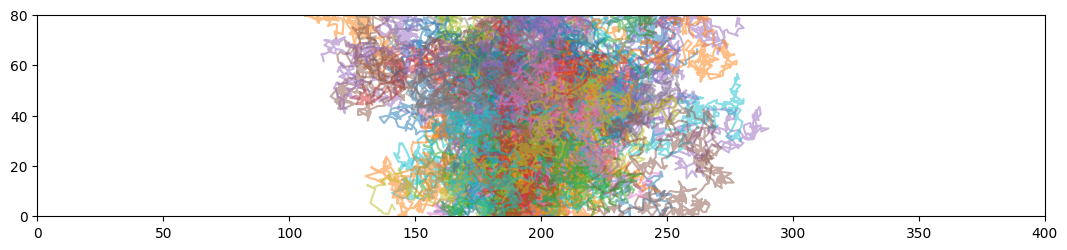

In [13]:
# Plot the random walks
fig, ax = plt.subplots(figsize=(13, 13))
ax.plot(*paths.swapaxes(0, 1).T, alpha=0.5)
ax.set_xlim(Q_MIN[0], Q_MAX[0])
ax.set_ylim(Q_MIN[1], Q_MAX[1])
ax.set(aspect='equal')
plt.show()

and in 3D with time as the vertical axis

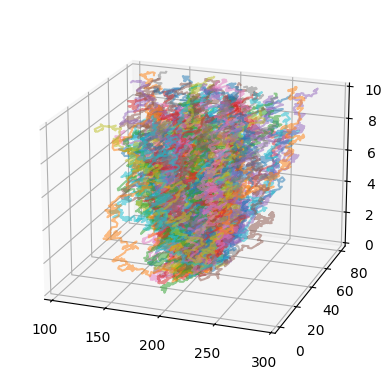

In [14]:
# Adapted from https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
ax = plt.axes(projection='3d')
for ns in range(num_samples):
    ax.plot3D( paths.swapaxes(0, 1).T[0, :, ns] ,
               paths.swapaxes(0, 1).T[1, :, ns] ,
               np.arange(1 + TAU / EPSILON) * EPSILON ,
               alpha=.5 )
ax.view_init(20, -70)

## Causal Entropic Forcing

Under causal entropic forcing, the agent-environment system has a momentum of
$$
\begin{align*}
    \mathbf{p}_t
    &=
    \mathbf{h} \left( \mathbf{x}_t \right)
    +
    \mathbf{f}^{(c)}(\mathbf{x}_t, \tau)
\end{align*}
$$

Here
$$
\begin{align*}
    \mathbf{f}^{(c)}(\mathbf{x}_t, \tau) = T_c \, \left. \nabla_{\mathbf{x}} \, s(\mathbf{x}, \tau) \right|_{\mathbf{x}_t}
\end{align*}
$$
is the causal entropic force on $\mathbf{x}_t$ with a time-horizon of $\tau$, where
* $T_c$ is the temperature of the environment when causal entropic forcing is performed
* $s(\mathbf{x}_t, \tau)$ is the causal entropy on $\mathbf{x}_t$ with time-horizon $\tau$ 

Causal entropy is defined by
$$
\begin{align*}
    s(\mathbf{x}_t, \tau) =
    - k_B \,
    \mathbb{E}_{p(\mathbf{x}_{t:t+\tau} \mid \mathbf{x}_t)}
    \left[
        \ln p(\mathbf{x}_{t:t+\tau} \mid \mathbf{x}_t)
    \right]
\end{align*}
$$
where $\mathbf{x}_{t:t+\tau}$ is a path in phase space from time $t$ to $t+\tau$.

### Calculating The Causal Entropic Force

[Wissner-Gross & Freer [2013a, Eq. 6]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) state that the $j$th component of $\left. \nabla_{\mathbf{x}} \, s(\mathbf{x}, \tau) \right|_{\mathbf{x}_t}$ is
$$
\begin{align*}
    \left. \frac{\partial}{\partial \, q_j} \, s(\mathbf{x}, \tau) \right|_{q_t}
\end{align*}
$$
because $\mathbf{q}$ is deterministic wrt $\mathbf{p}$ and $\mathbf{q}_t$ is deterministic wrt $\mathbf{p}_t$
$$
\begin{align*}
    p(\mathbf{x}_{t:t+\tau} \mid \mathbf{x}_t)
&=
    p( \{ \mathbf{q}_t, \mathbf{p}_t, \mathbf{q}_{t+\epsilon}, \mathbf{p}_{t+\epsilon}, \dots, \mathbf{q}_{t+\tau}, \mathbf{p}_{t+\tau} \} \mid \{ \mathbf{q}_t, \mathbf{p}_t \} )
\\
&=
    p( \{ \mathbf{q}_t, \mathbf{q}_{t+\epsilon}, \dots, \mathbf{q}_{t+\tau}, \} \mid \mathbf{q}_t )
\\
&=
    p( \mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q}_t )
\end{align*}
$$
so components wrt $p$s do not need to be calculated.

Denoting $\mathbf{l} = \mathbf{q}_{t+\epsilon:t+\tau}$ for mathematical convenience, and following [Hornischer [2015, p. 25]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content) for the gradient of the expectation term in the causal entropy
$$
\begin{align*}
    \left. \frac{\partial}{\partial \, q_j} \,
    \mathbb{E}_{\mathbf{l} \sim p(\mathbf{l} \mid \mathbf{q})}
    \left[
        \ln p(\mathbf{l} \mid \mathbf{q})
    \right]\right|_{q_{j, t}}
    &= \left.
    \int
        \frac{\partial}{\partial \, q_j} \,
        p(\mathbf{l} \mid \mathbf{q}) \ln p(\mathbf{l} \mid \mathbf{q})
        \,\mathrm{d} \mathbf{l}
    \right|_{q_{j, t}}
\\
    &= \left.
    \int
        \frac{\partial \, p(\mathbf{l} \mid \mathbf{q})}{\partial \, q_j}
        \ln p(\mathbf{l} \mid \mathbf{x}_t)
        + p(\mathbf{l} \mid \mathbf{q}) \frac{\partial \ln p(\mathbf{l} \mid \mathbf{q})}{\partial q_j}
        \,\mathrm{d} \mathbf{l}
    \right|_{q_{j, t}}
\\
    &=
    \int
        \left.
            \frac{\partial}{\partial \, q_j} p(\mathbf{l} \mid \mathbf{q})
        \right|_{q_{j, t}}
        \ln p(\mathbf{l} \mid \mathbf{x}_t)
    \,\mathrm{d} \mathbf{l}
\end{align*}
$$

The dynamics are Markovian and discrete-time
$$
\begin{align*}
    p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q}_t) = 
    p(\mathbf{q}_{t+\epsilon} \mid \mathbf{q}_t)
    \prod_{n=1}^{\tau/\epsilon-1}
        p(\mathbf{q}_{t + (n+1)\epsilon} \mid \mathbf{q}_{t + n\epsilon})
\end{align*}
$$

so
$$
\begin{align*}
    \left.
        \frac{\partial}{\partial \, q_j} p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q})
    \right|_{q_{j, t}}
&=
    \left.
        \frac{\partial}{\partial \, q_j} \,
        p(\mathbf{q}_{t+\epsilon} \mid \mathbf{q})
        \prod_{n=1}^{\tau/\epsilon-1}
            p(\mathbf{q}_{t + (n+1)\epsilon} \mid \mathbf{q}_{t + n\epsilon})
    \right|_{q_{j, t}}
\\
&=
    \left.
        \frac{\partial}{\partial \, q_j} \,
        p(\mathbf{q}_{t+\epsilon} \mid \mathbf{q}_t)
    \right|_{q_{j, t}}
    \prod_{n=1}^{\tau/\epsilon-1}
        p(\mathbf{q}_{t + (n+1)\epsilon} \mid \mathbf{q}_{t + n\epsilon})
\end{align*}
$$

Now
$$
\begin{align*}
    p(q_{j, t+\epsilon} \mid q_{j, t})
&=
    \mathcal{N} \left( \mu= q_{j, t} + h_j(\mathbf{x}_t) \frac{\epsilon^2}{m_{j}}, \sigma^2= k_B \, T_r \, \frac{\epsilon^2}{m_j} \right)
\end{align*}
$$

because $f$ is Normal and there is a reparameterization due to Langevin dynamics
$$
\begin{align*}
    q_{j, t+\epsilon}
    &= q_{j, t} + \dot{q}_{j, t} \, \epsilon
\\
    &= q_{j, t} + \frac{p_{j, t}}{m_{j}} \epsilon
% \\
%     &= q_{j, t} + \frac{p_{j, t} + \dot{p}_{j, t} \, \epsilon}{m_{j}} \epsilon
\\
    &= q_{j, t} + \frac{p_{j, t}}{m_{j}} \epsilon + \frac{
    - \frac{1}{\epsilon} \, p_{j, t} + f_{j, t} + h_j(\mathbf{x}_t)}{m_{j}} \epsilon^2
% \\
    % &= q_{j, t} + \frac{p_{j, t}}{m_{j}} \epsilon + \frac{f_{j, t} + h_j(\mathbf{x}_t)}{m_{j}} \epsilon^2
    % &= q_{j, t} + \left( f_{j, t} + h_j(\mathbf{x}_t) \right) \frac{\epsilon^2}{m_{j}}
    % &= q_{j, t} + \frac{f_{j, t} + h_j(\mathbf{x}_t)}{m_{j}} \epsilon^2
\\
    &= q_{j, t} + f_{j, t} \frac{\epsilon^2}{m_{j}} + h_j(\mathbf{x}_t) \frac{\epsilon^2}{m_{j}}
\end{align*}
$$

So, given that an arbitrary normal distribution has
$$
\begin{align*}
    \frac{\partial}{\partial x} p(x)
    &=
    \frac{\partial}{\partial x} \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(- \frac{(x - \mu)^2}{2 \sigma^2} \right)
\\
    &=
    - \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(- \frac{(x - \mu)^2}{2 \sigma^2} \right)
    \frac{\partial}{\partial x} \frac{(x - \mu)^2}{2 \sigma^2}
\\
    &=
    - \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(- \frac{(x - \mu)^2}{2 \sigma^2} \right)
    \frac{x - \mu}{\sigma^2}
\\
    &=
    - p(x) \frac{x - \mu}{\sigma^2}
\end{align*}
$$

the gradient we seek is
$$
\begin{align*}
    \left.
        \frac{\partial}{\partial \, q} \, p( q \mid q_{j, t} )
    \right|_{q_{j, t+\epsilon}}
&=
    p( q_{j, t+\epsilon} \mid q_{j, t} ) \frac{f_{j,t}}{k_B \, T_r}
\end{align*}
$$

Therefore, combining the steps above, the $j$th component of the causal entropic force is
$$
\begin{align*}
    f^{(c)}_j(\mathbf{x}_t, \tau)
    &=
    T_c \, \left. \frac{\partial}{\partial \, q_j} \, s(\mathbf{x}, \tau) \right|_{q_t}
\\
    &=
    - T_c \, k_B
    \int
        \left.
            \frac{\partial}{\partial \, q_j} p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q})
        \right|_{q_{j, t}}
        \ln p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q}_t)
    \,\mathrm{d} \mathbf{q}_{t+\epsilon:t+\tau}
\\
    &=
    - T_c \, k_B 
    \int
        \frac{f_{j, t}}{k_B \, T_r} \,
        p(\mathbf{q}_{t+\epsilon} \mid \mathbf{q}_t)
        \prod_{n=1}^{\tau/\epsilon-1}
            p(\mathbf{q}_{t + (n+1)\epsilon} \mid \mathbf{q}_{t + n\epsilon})
        \ln p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q}_t)
    \,\mathrm{d} \mathbf{q}_{t+\epsilon:t+\tau}
\\
    &=
    - \frac{T_c}{T_r} \,
    \mathbb{E}_{p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q}_t)}
    \left[
        f_{j, t} \,
        \ln p(\mathbf{q}_{t+\epsilon:t+\tau} \mid \mathbf{q}_t)
    \right]
\end{align*}
$$

My resultant expression differs from [Wissner-Gross & Freer [2013a, Eq. 11]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) and [Hornischer [2015, 3.1.20]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content) by a multiplicative factor of 2 and I am not sure why.
In practice, the multiplicative factor does not matter because I will multiply the specified values of $T_c$ by 2.

### Approximating The Entropic Force

[Wissner-Gross & Freer [2013b, p. 10]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702) approximate the integral in the above expression by $M$ Monte-Carlo samples $\mathbf{q}_{t+\tau}^{(i)}$s.
For convenience, denote the following conditional likelihood as 
$$
\begin{align*}
    p(\mathbf{q}_{t+\tau}^{(i)} \mid \mathbf{q}_t)
    =
    \frac{1}{M \, \Omega_i}
\end{align*}
$$

The $M$-sample Monte-Carlo estimate of the causal entropic force is
$$
\begin{align*}
    f^{(c)}_j(\mathbf{q}_t, \tau)
    &=
    - \frac{T_c}{T_r} \,
    \mathbb{E}_{\mathbf{q}_{t+\tau} \sim p(\mathbf{q}_{t+\tau} \mid \mathbf{q}_t)} [
        f_{j,t} \,
        \ln p(\mathbf{q}_{t+\tau} \mid \mathbf{q}_t)
    ]
\\
    &\approx - \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln p(\mathbf{q}_{t+\tau}^{(i)} \mid \mathbf{q}_t)
\\
    &= - \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \frac{1}{M \, \Omega_i}
\\
    &= \frac{T_c}{T_r}
    \frac{1}{M}
    \left(
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln M
    + \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
    \right)
\\
    &\approx \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
\end{align*}
$$

The first term in the penultimate line disappears because
$$
\begin{align*}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
&\approx
    0
\end{align*}
$$

Given
$$
\begin{align*}
    \left(
        \frac{1}{M}
        \sum_{i=1}^M
            f_{j,t}^{(i)}
    \right)
    \ln \sum_{i=1}^M
        \Omega_i
\approx
    0
\end{align*}
$$

$$
\begin{align*}
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
&\approx
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
    -
    \frac{T_c}{T_r}
    \left(
        \frac{1}{M}
        \sum_{i=1}^M
            f_{j,t}^{(i)}
    \right)
    \ln \sum_{i=1}^M
        \Omega_i
\\
&=
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
        \left(
            \ln \Omega_i
            - \ln \sum_{i=1}^M
                \Omega_i
        \right)
\\
&=
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
        \ln \frac{\Omega_i}{\sum_{i=1}^M \Omega_i}
\end{align*}
$$

and therefore
$$
\begin{align*}
    f^{(c)}_j(\mathbf{x}_t, \tau)
&\approx
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
        \ln \frac{\Omega_i}{\sum_{i=1}^M \Omega_i}
\end{align*}
$$

[Wissner-Gross & Freer [2013b, p. 10]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702) present an alternate derivation using an arithmetic average of the above quantity, represented by the angle brackets around the entire expression. They then use kernel density estimation (KDE) to compute $\Omega$. They do not explain how KDE is used. I guess that $p(\mathbf{q}_{t+\epsilon:t+\tau}^{(i)} \mid \mathbf{q}_t)$ is estimated by KDE performed on the entire sequence of positions (minus the start position) and used as follows:

Given
$$
\begin{align*}
    \Omega_i
    =
    {\frac{1}{M \, p(\mathbf{q}_{t+\epsilon:t+\tau}^{(i)} \mid \mathbf{q}_t)}}
\end{align*}
$$

$$
\begin{align*}
    \frac{\Omega_i}{\sum_{i=1}^M \Omega_i}
&=
    \frac
        {\frac{1}{M \, p(\mathbf{q}_{t+\epsilon:t+\tau}^{(i)} \mid \mathbf{q}_t)}}
        {\sum_{k=1}^M \frac{1}{M \, p(\mathbf{q}_{t+\epsilon:t+\tau}^{(k)} \mid \mathbf{q}_t)}}
\\&=
    \frac
        {\frac{1}{p(\mathbf{q}_{t+\epsilon:t+\tau}^{(i)} \mid \mathbf{q}_t)}}
        {\sum_{k=1}^M \frac{1}{p(\mathbf{q}_{t+\epsilon:t+\tau}^{(k)} \mid \mathbf{q}_t)}}
\end{align*}
$$

In [15]:
def log_volume_fracs(paths):
    volume       = 1. / scipy.stats.gaussian_kde(paths).pdf(paths)
    volume_fracs = volume / volume.sum() 
    return np.log(volume_fracs)

In practice, I subsample the paths because KDE over the entire sequence of positions is exceptionally high dimensional.

In [ ]:
def subsample(paths):
    # idea and code from Google Gemini to speed up KDE
    sub_indices = np.linspace( 0 ,
                               timesteps - 1 ,
                               NUM_SUBSAMPLES ,
                               dtype=int ) 
    sub_paths = paths[sub_indices, :, :]
    return sub_paths.transpose((2, 0, 1)).reshape(-1, num_samples)

In [16]:
def entropic_force(p, q, num_samples):
    paths, fs = rollouts(p, q, num_samples)
    sub_paths = subsample(paths[1:]) # remove first state bc conditional
    return np.mean( fs * log_volume_fracs(sub_paths)[:, None] , axis=0 )

now we run the causal entropic forces agent

In [17]:
p = np.array([0.   , 0.   ])
q = np.array([L/10., L/10.])

path = copy.deepcopy(q[None, :])

for timestep in range(100):
    print(timestep, q)
    num_samples = 50_000
    f_c  = 2 * T_C / T_R * entropic_force(p, q, num_samples)
    p, q = update_phase_space(p, q, f_c)
    path = np.append(path, q[None, :], axis=0)

0 [40. 40.]
1 [38.89262796 37.10979063]
2 [40.76007089 38.38024388]
3 [42.75206259 37.42445041]
4 [44.04958891 37.31010451]
5 [41.83567399 36.71110798]
6 [41.64396469 36.23805296]
7 [41.45058437 36.85940096]
8 [42.60299598 38.59145457]
9 [43.50092327 39.86008318]
10 [44.29848357 39.63080124]
11 [44.22555995 37.65148097]
12 [45.13703941 36.85895493]
13 [46.14379556 36.51763136]
14 [44.70333757 36.65442042]
15 [44.83096241 36.87722344]
16 [45.85066383 37.48102397]
17 [46.12631037 38.35699031]
18 [47.26616003 38.34709708]
19 [46.66357667 36.17324003]
20 [47.40864249 36.96123353]
21 [48.39911837 36.07465794]
22 [50.7718781  36.41485654]
23 [51.02530123 35.16076888]
24 [52.82367131 36.6516959 ]
25 [53.03931401 34.83906189]
26 [52.02729925 34.84044652]
27 [51.51250883 34.24487479]
28 [51.25401661 33.79861567]
29 [51.89091742 33.33617222]
30 [52.3910765  34.30013713]
31 [52.86945106 36.0985819 ]
32 [54.3491874  35.71639312]
33 [53.90023054 36.94746048]
34 [54.76931724 38.75544426]
35 [54.4551

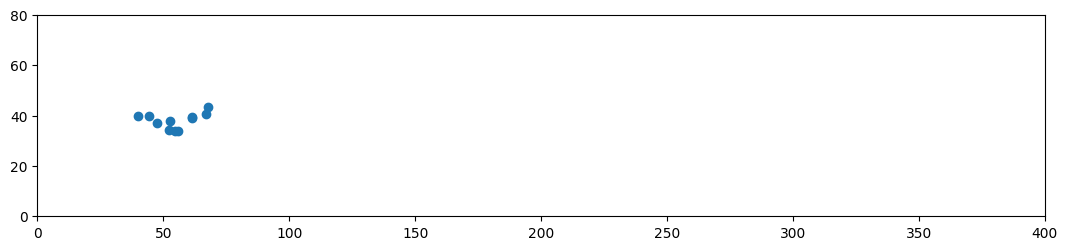

In [20]:
fig, ax = plt.subplots(figsize=(13, 13))
# from https://stackoverflow.com/a/37437395
# ax.add_patch(patches.Rectangle(Q_MIN, L, L/5., edgecolor='k', fill=False))
# ax.plot(*path.T)
ax.scatter(*path[::10].T)
ax.set_xlim(Q_MIN[0], Q_MAX[0])
ax.set_ylim(Q_MIN[1], Q_MAX[1])
ax.set(aspect='equal')
plt.show()